In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import os
import copy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
dirlist_motion = ['motion0001',
                  'motion0002',
                  'motion0004',
                  'motion0011',
                  'motion0012',
                  'motion0013',
                  'motion0014',
                  'motion0015',
                  'motion0017',
                  'motion0018',
                  'motion0019',
                  'motion0020',
                  'motion0028',
                  'motion0041',
                  'motion0068',
                  'motion0071',
                  'motion0116',
                  'motion0133',
                  'motion0147',
                  'motion0152',
                  'motion0154',
                  'motion0166',
                  'motion0181',
                  'motion0224',
                  'motion0252',
                  'motion0264',
                  'motion0273',
                  'motion0276'
                 ]
#dirlist_motion = dirlist_motion[-5:]

In [3]:
dirlist_focus = ['out_of_focus0001',
                'out_of_focus0006',
                'out_of_focus0009',
                'out_of_focus0012',
                'out_of_focus0025',
                'out_of_focus0031',
                'out_of_focus0032',
                'out_of_focus0037',
                'out_of_focus0044',
                'out_of_focus0066',
                'out_of_focus0082',
                'out_of_focus0083',
                'out_of_focus0086',
                'out_of_focus0088',
                'out_of_focus0094',
                'out_of_focus0113',
                'out_of_focus0142',
                'out_of_focus0145',
                'out_of_focus0154',
                'out_of_focus0160',
                'out_of_focus0176',
                'out_of_focus0188',
                'out_of_focus0198',
                'out_of_focus0199',
                'out_of_focus0204',
                'out_of_focus0206',
                'out_of_focus0209',
                'out_of_focus0215',
                'out_of_focus0223',
                'out_of_focus0288',
                'out_of_focus0247',
                'out_of_focus0252',
                'out_of_focus0269',
                'out_of_focus0333',
                'out_of_focus0351',
                'out_of_focus0369',
                'out_of_focus0375',
                'out_of_focus0387',
                'out_of_focus0395',
                'out_of_focus0399',
                'out_of_focus0458']
#dirlist_focus = dirlist_focus[-5:]

In [4]:
dirlist_solid = os.listdir('./extracted')[1000:]
dirlist = dirlist_motion+dirlist_focus#+dirlist_solid

In [5]:
feature_list = ['GHS','LK','LLF1','LLF2','LPSS','LST']
label_mark = 'GT'

In [6]:
def read_im_data(dirname,size):
    size = str(size)
    one_image_data = pd.DataFrame(data=None,columns=feature_list)
    for feature_name in feature_list:
        feature_data = pd.read_csv('./extracted/'+dirname+'/'+size+'/'+feature_name+'.csv',header=-1)
        feature_size = feature_data.values.shape[0]*feature_data.values.shape[1]
        one_image_data[feature_name] = list(map(lambda x: x[0],feature_data.values.reshape(feature_size,1)))
    one_image_labels = pd.read_csv('./extracted/'+dirname+'/'+size+'/'+label_mark+'.csv',header=-1)
    im_size = one_image_labels.shape
    one_image_labels = list(map(lambda x: x[0],one_image_labels.values.reshape(feature_size,1)))
    one_image_labels = pd.DataFrame(data=one_image_labels,columns=[label_mark])
    return one_image_data,one_image_labels,im_size

In [7]:
def show_result(y_pred,y_gt,im_size):
    y_pred = y_pred.reshape(im_size)
    y_gt = y_gt.reshape(im_size)
    plt.figure(1)
    plt.subplot(121)
    plt.imshow(y_gt)
    plt.subplot(122)
    plt.imshow(y_pred)

In [8]:
classifiers={'21': xgb.XGBClassifier(),
             '15': xgb.XGBClassifier(),
             '11': xgb.XGBClassifier()}

In [9]:
booster21 = xgb.Booster()
booster15 = xgb.Booster()
booster11 = xgb.Booster()
booster21.load_model('classifier21.bin')
booster15.load_model('classifier15.bin')
booster11.load_model('classifier11.bin')

In [10]:
#classifiers['21']._Booster = booster21
#classifiers['15']._Booster = booster15
classifiers['11']._Booster = booster11

In [11]:
columns_blur = ['blur'+str(n) for n in range(25)]
columns_clear = ['clear'+str(n) for n in range(25)]
columns_solid = ['solid'+str(n) for n in range(25)]
columns = columns_blur+columns_clear+columns_solid

In [12]:
from sklearn.feature_extraction.image import extract_patches_2d
def im2col(image,patch_size):
    patches = extract_patches_2d(image,patch_size)
    return list(map(lambda x: x.reshape(1,patch_size[0]*patch_size[1])[0],patches))

In [13]:
path_size = 5
def read_training_data(size):
    size = str(size)
    X = pd.DataFrame(data=None,columns=columns)
    y = pd.DataFrame(data=None,columns=[label_mark])
    for dirname in dirlist:
        one_image_data,one_image_labels,im_size = read_im_data(dirname,size)
        one_image_result = classifiers[size].predict_proba(one_image_data)
        
        one_image_blur = one_image_result[0][:int(one_image_result.shape[1]/2)].reshape(im_size)
        one_image_clear = one_image_result[1][:int(one_image_result.shape[1]/2)].reshape(im_size)
        one_image_solid = one_image_result[2][int(one_image_result.shape[1]/2):].reshape(im_size)
        
        one_image_blur = im2col(one_image_blur,(path_size,path_size))
        one_image_clear = im2col(one_image_clear,(path_size,path_size))
        one_image_solid = im2col(one_image_solid,(path_size,path_size))
        
        one_image_data = np.hstack((one_image_blur,one_image_clear,one_image_solid))
        X = pd.concat([X,pd.DataFrame(one_image_data,columns=X.columns)])
        
        one_image_labels = one_image_labels.values
        one_image_labels = one_image_labels.reshape(im_size)[int(path_size/2):-int(path_size/2),int(path_size/2):-int(path_size/2)]
        one_image_labels = one_image_labels.reshape(one_image_labels.shape[0]*one_image_labels.shape[1],1)
        
        y = pd.concat([y,pd.DataFrame(one_image_labels,columns=y.columns)])
    return X,y

In [14]:
def read_test_data(dirname,size):
    size = str(size)
    one_image_data,one_image_labels,im_size = read_im_data(dirname,size)
    one_image_result = classifiers[size].predict_proba(one_image_data)

    one_image_blur = one_image_result[0][:int(one_image_result.shape[1]/2)].reshape(im_size)
    one_image_clear = one_image_result[1][:int(one_image_result.shape[1]/2)].reshape(im_size)
    one_image_solid = one_image_result[2][int(one_image_result.shape[1]/2):].reshape(im_size)

    one_image_blur = im2col(one_image_blur,(path_size,path_size))
    one_image_clear = im2col(one_image_clear,(path_size,path_size))
    one_image_solid = im2col(one_image_solid,(path_size,path_size))

    one_image_data = np.hstack((one_image_blur,one_image_clear,one_image_solid))
    X = pd.DataFrame(one_image_data,columns=columns)

    one_image_labels = one_image_labels.values
    one_image_labels = one_image_labels.reshape(im_size)[int(path_size/2):-int(path_size/2),int(path_size/2):-int(path_size/2)]
    one_image_labels = one_image_labels.reshape(one_image_labels.shape[0]*one_image_labels.shape[1],1)

    y = pd.DataFrame(one_image_labels,columns=[label_mark])
    return X,y,im_size

In [15]:
X,y = read_training_data(11)

In [16]:
from sklearn.cross_validation import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

In [18]:
classifier = xgb.XGBClassifier()

In [19]:
classifier.fit(X_train,y_train)

C:\Programs\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [20]:
roc_auc_score(y_test.values,classifier.predict_proba(X_test)[:,1])

0.96642314001373342

In [21]:
classifier.booster().save_model('./stacking'+str(path_size)+'.bin')

In [38]:
X_test2,y_test2,size = read_test_data('out_of_focus0500',11)

In [39]:
roc_auc_score(y_test2.values,classifier.predict_proba(X_test2)[:,1])

0.94654196980567928

In [40]:
y_pred = classifier.predict_proba(X_test2)[:,1]

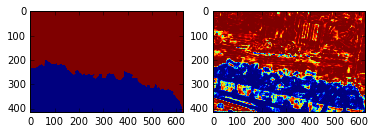

In [41]:
show_result(y_pred,y_test2.values,(size[0]-4,size[1]-4))